In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

%matplotlib inline

In [2]:
def solve_banded_system(x,y,h):
    
    """ takes in lists of x,y values and h values and cosntruct a banded system (tridiagonal matrix). 
        solves the system and returns result
    """
    n_unknowns = len(x) - 2    # number of unknowns
    
    A = np.zeros((n_unknowns,n_unknowns))
    v = np.zeros(n_unknowns)
        
    for i in range(n_unknowns):
        A[i][i] = 2*(h[i] + h[i+1])
        v[i] = 6*((y[i+2]-y[i+1])/h[i+1] - (y[i+1]-y[i])/h[i])
    
    for i in range(n_unknowns-1):
        A[i][i+1] = h[i+1]
        A[i+1][i] = h[i+1]
    
    return np.linalg.solve(A, v)

In [3]:
def construct_splines(fx_mapping):
    
    """ takes in a sequence of (x,y) points and for each section between two points calculates a cubic spline
    """
    n_points = len(fx_mapping)    # number of points
    n_splines = n_points - 1    # number of splines
    
    x = [item[0] for item in fx_mapping]    # get x values
    y = [item[1] for item in fx_mapping]    # get y values
    h = [x[i+1] - x[i] for i in range(n_splines)]    # calculate h values from x values
    
    # for each point calculate a value (store in m) - this value will be later used to calculate all coefficients
    m = np.zeros(n_points)
    m[1:-1] = solve_banded_system(x,y,h)
    
    # create a structured array to store spline coefficients and section lim[i]ts
    splines = np.zeros(n_splines, dtype=[("start", np.float64), ("end", np.float64), ("coefs",np.float64, 4)])
    
    # calculate coefficients using predefined, well known formulas
    for i in range(n_splines):
        
        c1 = (m[i+1]-m[i])/(6*h[i])
        c2 = (x[i+1]*m[i] - x[i]*m[i+1])/(2*h[i])
        c3 = (x[i]**2*m[i+1] - x[i+1]**2*m[i])/(2*h[i]) + (y[i+1]-y[i])/h[i] + (m[i]-m[i+1])*h[i]/6
        c4 = (x[i+1]**3*m[i]-x[i]**3*m[i+1])/(6*h[i]) + (x[i+1]*y[i]-x[i]*y[i+1])/h[i] + (x[i]*m[i+1]-x[i+1]*m[i])*h[i]/6
        
        splines[i]["start"] = x[i]
        splines[i]["end"] = x[i+1]
        splines[i]["coefs"] = [c1,c2,c3,c4]
        
    return splines

In [4]:
def make_func(coefs):
    
    """ coefs is a list/array of a polynomial coefficients.
        returns a convenient function that calculates function value at given point x
    """
    n = len(coefs)
    
    def f(x):
        return sum([coefs[i]*x**(n-1-i)  for i in range(n)])
    
    return f

In [5]:
def calculate_derivative(coefs):
    
    """ coefs is a list/array of a polynomial coefficients.
        returns a list of coefficients of polynomial derivative
    """
    n = len(coefs)
    
    derivative_coefs = [(n-1-i)*coefs[i] for i in range(n)]
    return derivative_coefs[:-1] # slice last item from the list to reduce order by 1

In [10]:
def calculate_plot_spline(fx_mapping):
    
    """ calculates a cubic spline for the given points in fx_mapping, then calculates first and second derivatives
        plots all three functions
    """
    splines = construct_splines(fx_mapping)
    colors = ["darkblue", "darkorange", "darkgreen", "tomato", "darkmagenta"]    # every section/spline has its own color
    
    plt.figure(figsize=(16,9))

    for spl in splines:

        start = spl["start"]
        end = spl["end"]
        spl_index = np.where(splines==spl)[0][0]    # get the index of the spline to determine its color

        x = np.arange(start,end,0.001) # set section dots for plotting
        f = make_func(spl["coefs"])

        derivative1 = calculate_derivative(spl["coefs"]) # get the coefficients of first derivative
        f_tag = make_func(derivative1)

        derivative2 = calculate_derivative(derivative1) # get the coefficients of second derivative
        f_tag2 = make_func(derivative2)

        plt.plot(x, f(x), c=colors[spl_index])
        plt.plot(x, f_tag(x), c=colors[spl_index], linestyle="--")
        plt.plot(x, f_tag2(x), c=colors[spl_index], linestyle=":")


    # set legend
    lines = [Line2D([0], [0], color="darkblue", linewidth=1.5, linestyle=st) for st in ["-", "--", ":"]]
    labels = ["cubic spline", "first derivative", "second derivative"]
    plt.legend(lines, labels, prop={'size': 15})
    plt.show()
#     plt.savefig("fig1.png")

In [11]:
def calculate_plot_parameteric_spline(fx_mapping):
    
    """ calculates a cubic spline, using a parameter, for the given points in fx_mapping
        plots parametric spline
    """
    
    # parameterize x and y values. Seperate them into two different arrays, adding index parameter to every point
    n = len(fx_mapping)
    x_map = [(i,fx_mapping[i][0]) for i in range(n)]
    y_map = [(i,fx_mapping[i][1]) for i in range(n)]
    
    # add another point at the end, to get a closed curve
    x_map.append((n,x_map[0][1]))
    y_map.append((n,y_map[0][1]))

    x_splines = construct_splines(x_map)
    y_splines = construct_splines(y_map)

    plt.figure(figsize=(16,9))

    for i in range(n):
        x_spl = x_splines[i]
        y_spl = y_splines[i]
        start = x_spl["start"]
        end = x_spl["end"]

        if start > end:
            start = x_spl["end"]
            end = x_spl["start"]

        t = np.arange(start,end,0.001) # set section dots for plotting
        x = make_func(x_spl["coefs"])
        y = make_func(y_spl["coefs"])

        plt.plot(x(t), y(t))

    plt.show()
#     plt.savefig("fig2.png")

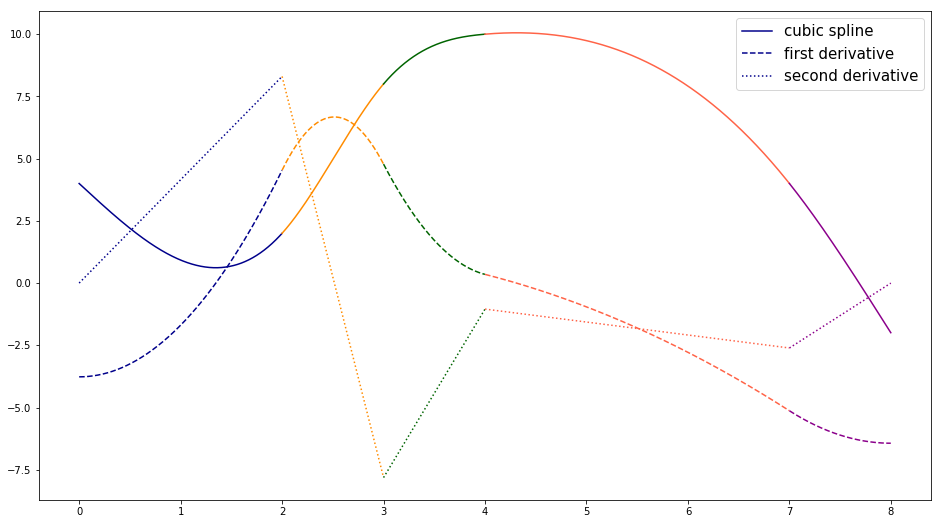

In [12]:
fx_mapping1 = [(0,4), (2,2), (3,8), (4,10), (7,4), (8,-2)]
calculate_plot_spline(fx_mapping1)

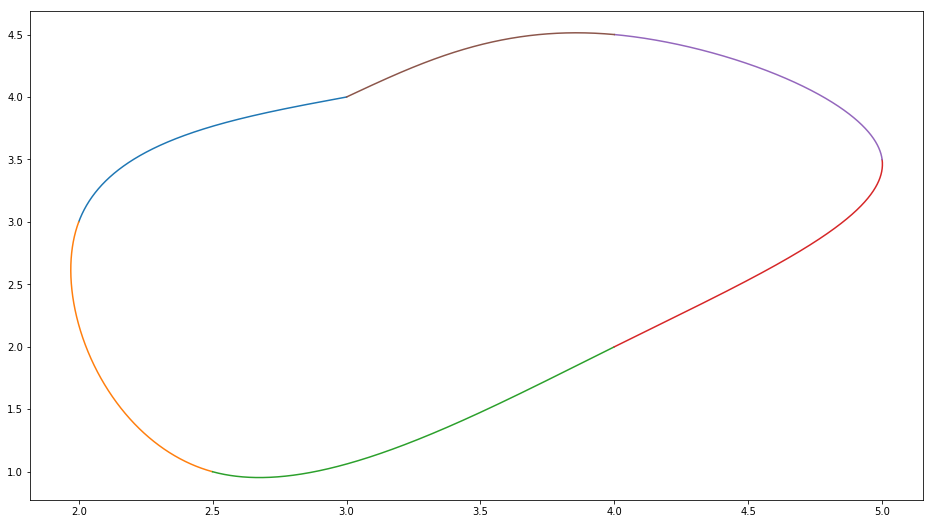

In [13]:
fx_mapping2 = [(3,4), (2,3), (2.5,1), (4,2), (5,3.5), (4,4.5)]
calculate_plot_parameteric_spline(fx_mapping2)